In [1]:
from alarmEnv import environment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Test Functions

In [2]:
"""
Softmax function
"""
def softmax(vals, dex):
    return np.exp(vals[dex])/np.sum(np.exp(vals))

"""
Creates an environment with a given set of parameters, runs it, and returns the corresponding results
"""
def test(params, seed = 0, steps = None, thresh = None):
    # create the environment
    env = environment(predfreq = params[0], accalarm = params[1], falarm = params[2], conresp = params[3],
                      preddet = params[4], alarmdet = params[5], condet = params[6], predr = params[7],
                      conr = params[8], lrate = .05, topology = [1, 2], actfunc = 's', seed = seed)
    # run and grab the value
    res = env.run(steps, thresh)
    # if there is a threshold, just return the number of steps it took
    if thresh:
        return res
    # otherwise, calculate the probability of fleeing with an alarm and foraging without an alarm
    else:
        # if this is a vigilance only run, just look at fleeing and foraging without an alarm
        if params[5] == 0:
            return (softmax(res[1], 1), softmax(res[1], 0))
        # otherwise compare with and without alarm
        return (softmax(res[0], 1), softmax(res[1], 0))

In [3]:
"""
Replicates a given test n times and returns the average
"""

def replicate(params, n, steps = None, thresh = None):
    # initialize array to hold results
    if steps:
        results = np.zeros((n, 2))
    if thresh:
        results = np.zeros((n, 1))
    
    # test for the given set of parameters for seeds 0 to n
    for i in range(n):
        results[i, :] = test(params, seed = i, steps = steps, thresh = thresh)
    
    # return the mean
    return np.mean(results, axis = 0)

In [4]:
"""
Loop through a list of values for a given parameter and return an array of the results (based on threshold or total number of steps).
paramdex - index of where the parameter appears as an argument to environment
vals - list of values of that parameter to check
replicates - number of runs to average over
baseparams - list of baseline parameter values (assumed optimal unless given others)
thresh - threshold error value for stopping training
steps - the total number of steps of training
"""
def testParam(paramdex, vals, baseparams, replicates = 1, steps = None, thresh = None):
    # initialize a numpy array to hold the results
    # if using a threshold, it just needs to be one dimensional
    if thresh:
        results = np.zeros(vals.shape[0])
    # otherwise, it needs to have one column for the response to an alarm and one for the absence of an alarm
    else:
        results = np.zeros((vals.shape[0], 2))
    
    # copy baseparams to get a new list into which the parameters can be inserted
    params = np.copy(baseparams)
    
    # loop through a range of provided parameter values
    for v in range(vals.shape[0]):
        # grab the actual value
        val = vals[v]
        # change the parameter value
        params[paramdex] = val
        # run the environment and get the results
        res = replicate(params, replicates, steps, thresh)
        # add the results into the corresponding list
        if thresh:
            results[v] = res
        else:
            results[v, 0] = res[0]
            results[v, 1] = res[1]
    # once it's all done, return the results array
    return results

In [5]:
"""
Plot probability of response over values of a single parameter
"""
def plotOne(xvals, yvals, legend = None, name = None, pname = None, yname = None):
    plt.plot(xvals, yvals, 'o-')
    if legend is not None:
        plt.legend(legend)
    if pname:
        plt.xlabel(pname + "Value")
    else:
        plt.xlabel("Parameter Value")
    if yname:
        plt.ylabel(yname)
    else:
        plt.ylabel("Probability of Response")
    if name:
        plt.title(name)
    plt.ylim(0, 1)
    plt.show()


"""
Plot probability of response as an image over values of two parameters
"""
def plotTwo(error, name = None, p1name = None, p2name = None):
    plt.imshow(error, cmap = "hot", origin = 'lower')
    plt.colorbar()
    # set the title
    if name:
        plt.title(name)
    # label the axes
    if p1name:
        plt.xlabel(p1name)
    if p2name:
        plt.ylabel(p2name)
    plt.show()

In [6]:
"""
Return probabilities in response to an alarm and absence of an alarm over a range of values of two parameters
"""
def testTwo(paramdex1, paramdex2, vals1, vals2, steps, baseparams, replicates = 1):
    # initialize two arrays to hold the results
    alarm = np.zeros((vals1.shape[0], vals2.shape[0]))
    noalarm = np.zeros((vals1.shape[0], vals2.shape[0]))
    # copy baseparams
    params = np.copy(baseparams)
    # loop through all the values of param 1 and test all possible values of param 2 for each
    for v in range(vals1.shape[0]):
        # change baseparams to match this value of param 1
        params[paramdex1] = vals1[v]
        # test all possible values of param 2 with this value of param 1
        results = testParam(paramdex2, vals2, params, replicates = replicates, steps = steps)
        # split the results into alarm and noalarm and add to the respective arrays
        alarm[v, :] = results[:, 0]
        noalarm[v, :] = results[:, 1]
    # return both arrays
    return alarm, noalarm

In [7]:
"""
Return probabilities over pairs of parameter values
"""
def testPair(paramdex1, paramdex2, vals1, vals2, steps, baseparams, replicates = 1):
    # initialize an array to hold the results
    results = np.zeros((vals1.shape[0], 2))
    # copy baseparams
    params = np.copy(baseparams)
    # loop through all paired values of params 1 and 2 to test with all values of param 3
    for v in range(vals1.shape[0]):
        # change baseparams to match this value of param 1
        params[paramdex1] = vals1[v]
        # change baseparams to match the corresponding value of param 2
        params[paramdex2] = vals2[v]
        # test this pair of values
        res = replicate(params, n = replicates, steps = steps)
        # split the results into alarm and noalarm and add to the respective arrays
        results[v, 0] = res[0]
        results[v, 1] = res[1]
    # return the array of results
    return results

In [8]:
"""
Tests all values of param 3 against paired values of params 1 and 2
"""
def testTrio(paramdex1, paramdex2, paramdex3, vals1, vals2, vals3, steps, baseparams, replicates = 1):
    # initialize alarm and no alarm arrays to hold the results
    alarm = np.zeros((vals1.shape[0], vals3.shape[0]))
    noalarm = np.zeros((vals1.shape[0], vals3.shape[0]))
    # copy baseparams
    params = np.copy(baseparams)
    # loop through all paired values of params 1 and 2
    for v in range(vals1.shape[0]):
        # change baseparams to match this value of param 1
        params[paramdex1] = vals1[v]
        # change baseparams to match the corresponding value of param 2
        params[paramdex2] = vals2[v]
        # test this pair of values on all values of param 3
        res = testParam(paramdex3, vals3, params, replicates = replicates, steps = steps)
        # split the results into alarm and noalarm and add to the respective arrays
        alarm[v, :] = res[:, 0]
        noalarm[v, :] = res[:, 1]
    return alarm, noalarm

# Social versus Individual Learning

Based on the mathematical model, I predict that social learning models and individual learning models should perform the same in response to the absence of an alarm, but in any case where there are false alarms (or percieved false alarms), the social learning model should perform better than individual learning models in response to an alarm.

In [17]:
"""
For each trial, I will vary the value of the given parameter between 0 and 1, at intervals of .1,
and plot the probability of response in the individual and social learning conditions, with and without an alarm, in each case
"""
def socvindvTest(paramdex, paramname):
    # I will initialize the base parameters to be the same for each trial - in the individual learning condition:
    # predfreq = .5, accalarm = .5, falarm = .5, conresp = .5, preddet = 1, alarmdet = 1, condet = 0, predr = 1, conr = 0
    indvparams = [.5, .5, .5, .5, 1, 1, 0, 1, 0]
    # base parameters for the social learning condition:
    # predfreq = .5, accalarm = .5, falarm = .5, conresp = .5, preddet = 1, alarmdet = 1, condet = 1, predr = 1, conr = 1
    socparams = [.5, .5, .5, .5, 1, 1, 1, 1, 1]
    # now also featuring a vigilance only condition
    # predfreq = .5, accalarm = .5, falarm = .5, conresp = .5, preddet = 1, alarmdet = 0, condet = 0, predr = 1, conr = 0
    vigparams = [.5, .5, .5, .5, 1, 0, 0, 1, 0]
    
    # I will vary the designated parameter from 0 to 1, with 10 replicants and 500 steps for each condition
    indvres = testParam(paramdex, np.arange(0, 1.1, .1), indvparams, replicates = 10, steps = 500)
    socres = testParam(paramdex, np.arange(0, 1.1, .1), socparams, replicates = 10, steps = 500)
    vigres = testParam(paramdex, np.arange(0, 1.1, .1), vigparams, replicates = 10, steps = 500)
    
    # split the results into alarm and no alarm
    alarm = np.zeros((11, 3))
    alarm[:, 0] = vigres[:, 0]
    alarm[:, 1] = indvres[:, 0]
    alarm[:, 2] = socres[:, 0]
    
    noalarm = np.zeros((11, 3))
    noalarm[:, 0] = vigres[:, 1]
    noalarm[:, 1] = indvres[:, 1]
    noalarm[:, 2] = socres[:, 1]
    
    # Note: in the no-alarm condition, individual error is the same as social error
    
    # store name for alarm and no alarm
    alarmname = "Effect of " + paramname + " on Response to Alarm"
    noalarmname = "Effect of " + paramname + " on Response to No Alarm"
    
    # I will compare the two conditions in the presence of an alarm
    plotOne(np.arange(0, 1.1, .1), alarm, legend = ["Vigilance Only", "Individual learning", "Social learning"], name = alarmname, pname = paramname, yname = "Probability of Fleeing")
    # and in the absence of an alarm
    plotOne(np.arange(0, 1.1, .1), noalarm[:,:2], legend = ["Vigilance Only", "Individual and Social learning"], name = noalarmname, pname = paramname, yname = "Probability of Foraging")

## Predator Frequency

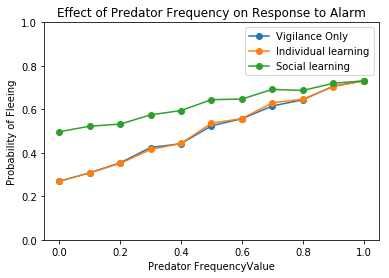

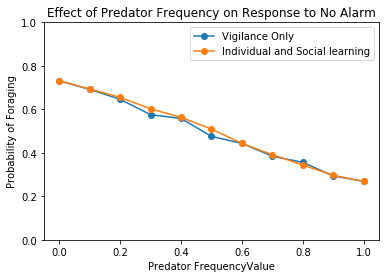

In [18]:
socvindvTest(0, "Predator Frequency")

## Accurate Alarm Frequency

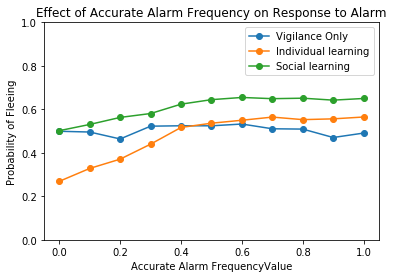

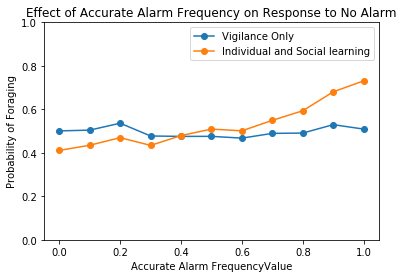

In [19]:
socvindvTest(1, "Accurate Alarm Frequency")

## False Alarm Frequency

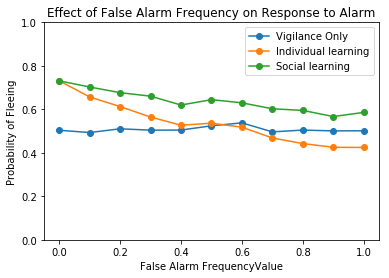

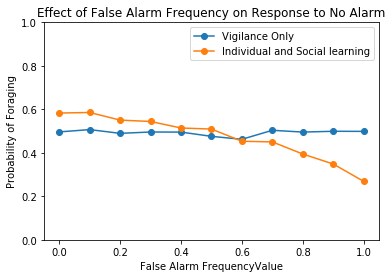

In [20]:
socvindvTest(2, "False Alarm Frequency")